In [1]:
from fastai2.vision.all import *
from knockknock import email_sender

In [2]:
root_dir = Path('/')
data_dir = root_dir / 'data' / 'chest_xray'
model_dir = Path('.').absolute() / 'models'

In [3]:
sz = 256
lr = defaults.lr
bs = 64
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

In [4]:
def valid_func(o: Path):
    return 'test' in str(o)

def label_func(o: Path):
    if 'virus' in o.name:
        return 'pneumonia'
    if 'bacteria' in o.name:
        return 'pneumonia'
    return 'normal'

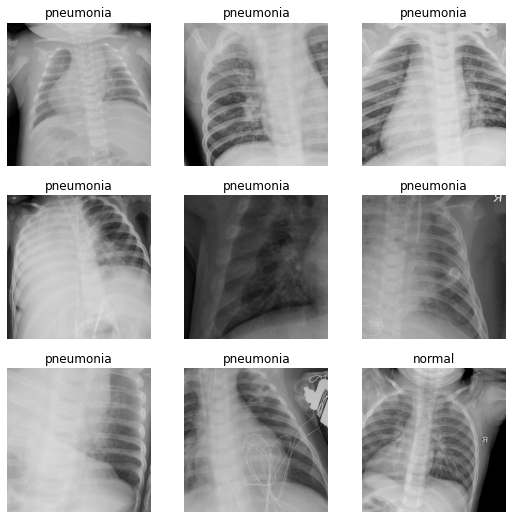

In [5]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=FuncSplitter(valid_func),
                 get_y=label_func,
                 item_tfms=Resize(sz*2),
                 batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*stats)])

data = db.dataloaders(data_dir)
data.show_batch(max_n=9)

In [6]:
learn = cnn_learner(data,
                    resnet50,
                    metrics=error_rate,
                    bn_wd=False,
                    loss_func=LabelSmoothingCrossEntropy(),
                    cbs=[BnFreeze,
                          SaveModelCallback(monitor='error_rate', name='best_error'),
                          ShowGraphCallback,
                         ],
                    model_dir=model_dir,
                   ).to_fp16()

In [7]:
@email_sender(recipient_emails=["yyang@hbku.edu.qa"], sender_email="hbkubot@gmail.com")
@delegates(learn.fit_one_cycle)
def train(learn, name, lr, n_epochs=5, **kwargs): # must be called kwargs, not kw_args or anything else
    learn.fit_one_cycle(n_epochs, lr, **kwargs)
    learn.save(name)

epoch,train_loss,valid_loss,error_rate,time
0,0.674430,0.652477,0.155449,00:18
1,0.440287,0.534550,0.136218,00:17
2,0.349524,0.439427,0.110577,00:17
3,0.312161,0.452100,0.133013,00:17
4,0.301627,0.433913,0.110577,00:17


Better model found at epoch 0 with error_rate value: 0.15544871985912323.


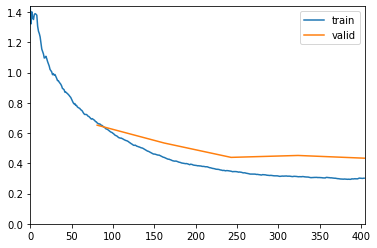

Better model found at epoch 1 with error_rate value: 0.13621795177459717.
Better model found at epoch 2 with error_rate value: 0.11057692021131516.


In [8]:
train(learn, 'stage_1', lr)

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

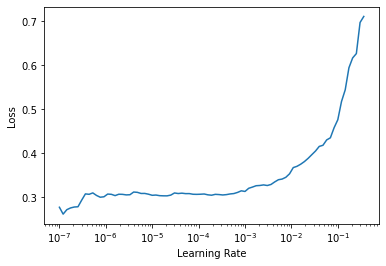

In [9]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,0.305368,0.459796,0.147436,00:21
1,0.297576,0.427266,0.112179,00:21
2,0.276745,0.379880,0.096154,00:21
3,0.263425,0.388695,0.097756,00:21
4,0.256104,0.388422,0.102564,00:21


Better model found at epoch 0 with error_rate value: 0.14743590354919434.


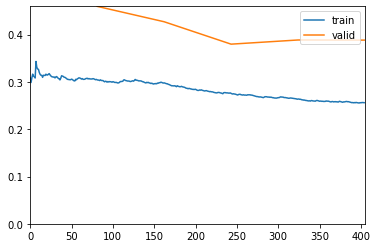

Better model found at epoch 1 with error_rate value: 0.11217948794364929.
Better model found at epoch 2 with error_rate value: 0.09615384787321091.


In [10]:
lr = 3e-4
train(learn, 'stage_2', slice(lr/100, lr))

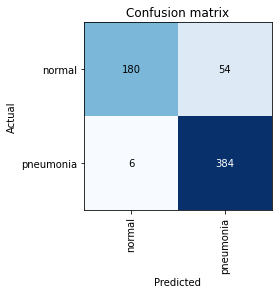

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()